## Face Recogniton and Siamese Model - Attendance System

### Importing Libraries


In [34]:
import tensorflow as tf
import numpy as np
from keras_facenet import FaceNet
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from utils.face_mtcnn import *
import csv
import datetime

### Loading model


In [2]:
embedder = FaceNet()

### Loading images


In [3]:
base_dir = "data/train_images"
persons = os.listdir(base_dir)
images = {}
# image_paths = []
for person in persons:
    images[person] = []
    paths = os.listdir(os.path.join(base_dir,person))[:5]
    for path in paths:
        # image_paths.append(os.path.join(base_dir,person,path))
        images[person].append(cv2.cvtColor(cv2.imread((os.path.join(base_dir,person,path))),cv2.COLOR_BGR2RGB))
print("Total number of people found = ", len(images))


Total number of people found =  3


(-0.5, 639.5, 639.5, -0.5)

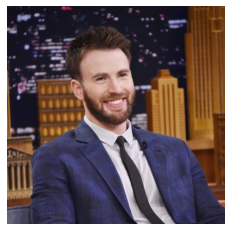

In [4]:
#sample image
plt.imshow(images['Chris'][2] , cmap = "gray")
plt.axis("off")

### Face Detection and Cropping


In [5]:
def Face_detection(images):
    
    crop_img = {}
    
    # faceCascade= cv2.CascadeClassifier("utils/haarcascade_frontalface_default.xml")
    for a in images.keys():
        crop_img[a] = []
        for img in images[a]:
            faces = detect_Faces_img(img)
            if len(faces) != 0:
                for b in faces:
                    (x,y,w,h) = b['box']
                    Cropped = img[y : y + h , x: x+w ]
                    crop_img[a].append(Cropped)  
        
    return crop_img

In [6]:
# cropped images
Crop_Images = Face_detection(images)

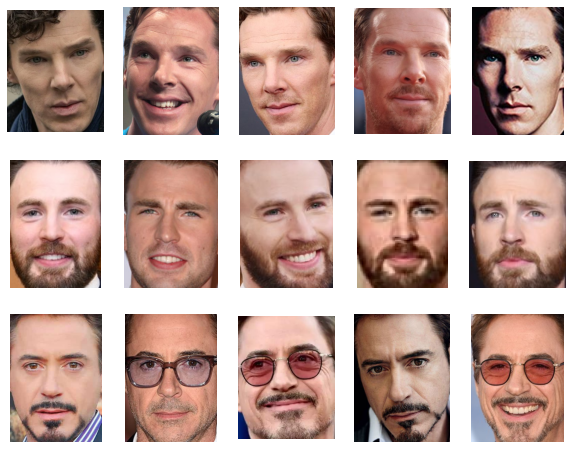

In [8]:
#plotting various faces found in our dataset!

fig , ax = plt.subplots(len(Crop_Images), 5 , figsize = (10,8))
i=1
for a in Crop_Images.keys():
    for j in range(5):
        plt.subplot(3,5,i)
        plt.axis("off")
        plt.imshow(Crop_Images[a][j])
        i += 1


### Embedding Extraction

In [9]:
embeddings = {}
for a in Crop_Images.keys():
    embeddings[a] = embedder.embeddings(Crop_Images[a])

In [10]:
#creating a database for people we expect to visit us.
database_size = 5
database = {}
for person in persons:
    database[str(person)] = embeddings[person][:database_size]
        
database

{'Ben': array([[-0.01795235, -0.02363339, -0.00272109, ..., -0.00244025,
         -0.02164875, -0.03304688],
        [ 0.00653493, -0.03710208,  0.0345618 , ...,  0.00255678,
         -0.07484119, -0.07949924],
        [ 0.02244694, -0.0632055 ,  0.01371152, ..., -0.01638585,
         -0.01576117, -0.08940025],
        [ 0.01774295, -0.0409545 ,  0.00835492, ...,  0.02975539,
         -0.03518092, -0.08887043],
        [ 0.02795202, -0.06151393,  0.02411076, ..., -0.00292438,
         -0.01059645, -0.09036852]], dtype=float32),
 'Chris': array([[-0.00556478,  0.00074929, -0.00499367, ..., -0.00654495,
         -0.00625114, -0.02765532],
        [ 0.00478884,  0.0552065 ,  0.0302975 , ...,  0.04145799,
          0.066743  , -0.03033401],
        [ 0.00169897, -0.01162907,  0.03835967, ...,  0.00347301,
         -0.00251314, -0.02639209],
        [ 0.01206494,  0.04434022,  0.02690631, ..., -0.01269804,
          0.00889455, -0.03764299],
        [-0.00637959,  0.01248587, -0.01231052, .

In [11]:
database['Ben'].shape

(5, 512)

### Testing

In [35]:
def save_attendance(present):
    # open the file in the write mode
    f = open('log.csv', 'a')

    # create the csv writer
    writer = csv.writer(f)
    for a in present:
        # write a row to the csv file
        writer.writerow([a, datetime.datetime.now()])

    # close the file
    f.close()

In [36]:
def Face_recog(image_path , alpha = 2, output_file = False):
    '''
    image_path : list of individual input image path.
    alpha : it is a hyperparameter
    '''
    
    #detecting face
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    faces = detect_Faces_img(img)
    crop_imgs = []
    if len(faces) != 0:
        for b in faces:
            (x,y,w,h) = b['box']
            Cropped = img[y : y + h , x: x+w ]
            crop_imgs.append(Cropped)  

    present = []
 
    img_embedding = embedder.embeddings(crop_imgs)
    # for crop in crop_imgs:
    #     img_embedding.append(embedder.embeddings(crop))
    
    #calculate dist wrt to database images
    min_dist = 100
    i=0

    for embedding in img_embedding:
        for (name,db_emb) in database.items():
            
            for emb in db_emb:
            
                dist = np.linalg.norm(embedding - db_emb)
                
                if dist < min_dist:
                    min_dist = dist
                    identity = name
        
        plt.axis("off")
        plt.imshow(crop_imgs[i])
        plt.show()
        i += 1    
        if min_dist > alpha:
            print("Not found in Database")
            
        else:
            print(f"{identity} identified")
            present.append(identity)
    
    if output_file:
        save_attendance(present)
    

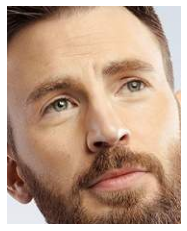

Chris identified


In [37]:
test_img_path = 'data/test/00000042.jpeg'
Face_recog(test_img_path, output_file= True)

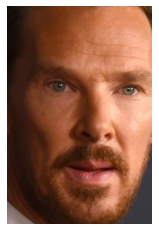

Ben identified


In [39]:
test_img_path = 'data/test/00000082.jpeg'
Face_recog(test_img_path, output_file=True)

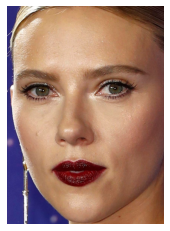

Not found in Database


In [20]:
test_img_path = 'data/test/00000063.jpeg'
Face_recog(test_img_path)

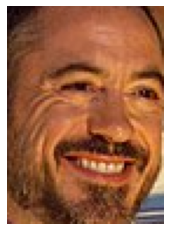

Robert identified


In [40]:
test_img_path = 'data/test/00000053.jpeg'
Face_recog(test_img_path, output_file=True)

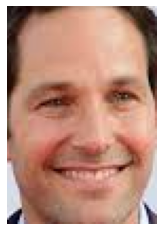

Not found in Database


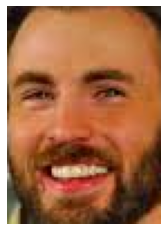

Chris identified


In [17]:
test_img_path = 'data/test/test3.jpg'
Face_recog(test_img_path)

In [ ]:
### Alter algo